In [1]:
import os as os
import warnings

import cudaq
import matplotlib.pyplot as plt
import pandas as pd
from bigdatavqa.ansatz import get_QAOA_circuit, get_VQE_circuit
from bigdatavqa.coreset import BFL2, D2_sampling
from bigdatavqa.Hamiltonians import get_K3_Hamiltonian
from bigdatavqa.k3meansclustering import (
    K3MeansClusteringKMeans,
    K3MeansClusteringMaxCut,
    K3MeansClusteringRandom,
    K3MeansClusteringVQA,
)
from bigdatavqa.optimizer import get_optimizer_for_QAOA, get_optimizer_for_VQE

warnings.filterwarnings("ignore")

In [2]:
qubits = 10
number_of_qubits_representing_data_point = 2
coreset_size = int(qubits / number_of_qubits_representing_data_point)
circuit_depth = 1
max_shots = 1000
max_iterations = 100
number_of_experiment_runs = 5
number_of_corsets_to_evaluate = 15
number_of_centroid_evaluation = 20

In [3]:
raw_data = BFL2.create_dataset(1000)

coreset = BFL2(
    raw_data=raw_data,
    number_of_sampling_for_centroids=10,
    coreset_size=coreset_size,
    number_of_coresets_to_evaluate=4,
    sampling_method=D2_sampling,
)


coreset_vectors, coreset_weights = coreset.get_best_coresets()

vector_columns = ["X", "Y"]
weights_column = "weights"

coreset_df = pd.DataFrame(coreset_vectors, columns=list("XY"))
coreset_df[weights_column] = coreset_weights
coreset_df["Name"] = [chr(i + 65) for i in coreset_df.index]
coreset_df

,X,Y,weights,Name
0,9.410859,-1.930344,47.282568,A
1,-0.969964,0.998846,294.451156,B
2,-0.218797,0.298648,183.003418,C
3,0.549347,-1.254952,258.916629,D
4,6.433227,1.661365,172.147854,E


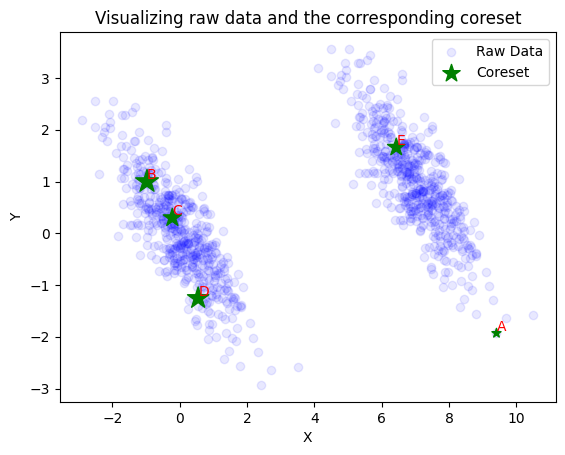

In [4]:
plt.scatter(raw_data[:, 0], raw_data[:, 1], color="blue", alpha=0.09, label="Raw Data")
plt.scatter(
    coreset_df.X,
    coreset_df.Y,
    s=coreset_df.weights,
    marker="*",
    color="green",
    label="Coreset",
)
for idx, row in coreset_df.iterrows():
    plt.annotate(row["Name"], xy=(row.X, row.Y + 0.05), color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Visualizing raw data and the corresponding coreset")
plt.show()

## VQE K3 clustering

In [5]:
optimizer = cudaq.optimizers.COBYLA()

k3meansVQE = K3MeansClusteringVQA(
    full_coreset_df = coreset_df,
    vector_columns=vector_columns,
    weights_columns=weights_column,
    qubits=qubits,
    create_circuit=get_VQE_circuit,
    circuit_depth=1,
    optimizer_function=get_optimizer_for_VQE,
    optimizer=optimizer,
    create_Hamiltonian=get_K3_Hamiltonian,
    number_of_qubits_representing_data=number_of_qubits_representing_data_point,
    normalize_vectors=True,
    max_iterations=max_iterations,
    max_shots=max_shots,
)



k3meansVQE.fit()

VQE_cost = k3meansVQE.cost
print(f"VQE cost: {VQE_cost}")

VQE cost: 111.53521162889477


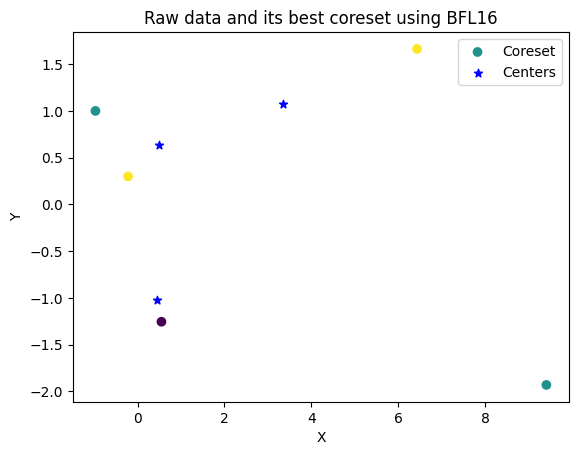

In [6]:
k3meansVQE.plot()

## KMeans clustering

In [7]:
k3meansKMeans = K3MeansClusteringKMeans(
    full_coreset_df=coreset_df,
    vector_columns=vector_columns,
    weights_columns=weights_column,
    number_of_qubits_representing_data=number_of_qubits_representing_data_point,
    normalize_vectors=True,
)

k3meansKMeans.fit()

KMeans_cost = k3meansKMeans.cost
print(f"KMeans cost: {KMeans_cost}")




KMeans cost: 80.47898638343584


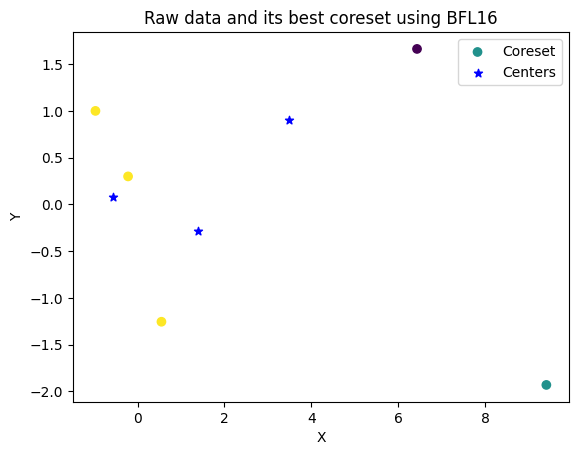

In [8]:
k3meansKMeans.plot()

## Random clustering

In [9]:
k3meansRandom = K3MeansClusteringRandom(
    coreset_df,
    vector_columns,
    weights_column,
    False,
    number_of_qubits_representing_data_point,

)

k3meansRandom.fit()

Random_cost = k3meansRandom.cost

print(f"Random cost value: {Random_cost}")

Random cost value: 128.13831207588115


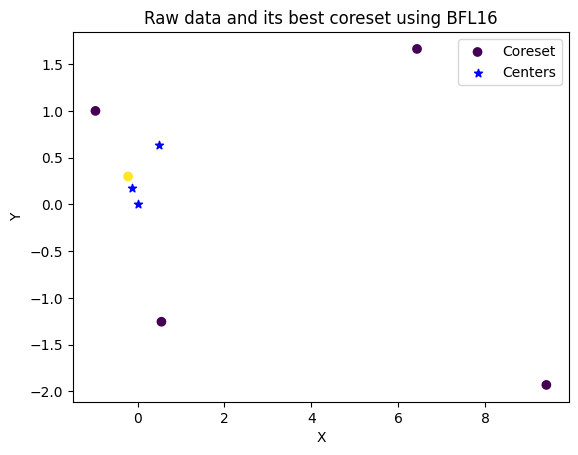

In [10]:
k3meansRandom.plot()

## MaxCut

In [11]:
k3MeansMaxCut = K3MeansClusteringMaxCut(
    coreset_df,
    vector_columns,
    weights_column,
    False,
    number_of_qubits_representing_data_point,
)

k3MeansMaxCut.fit()

MaxCut_cost = k3meansKMeans.cost

print(f"MaxCut cost value: {MaxCut_cost}")

100%|██████████| 1022/1022 [00:01<00:00, 741.83it/s]

MaxCut cost value: 80.47898638343584


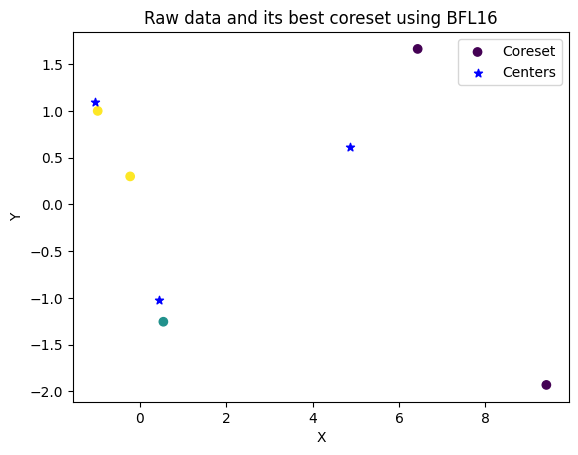

In [12]:
k3MeansMaxCut.plot()

# Analyzing results

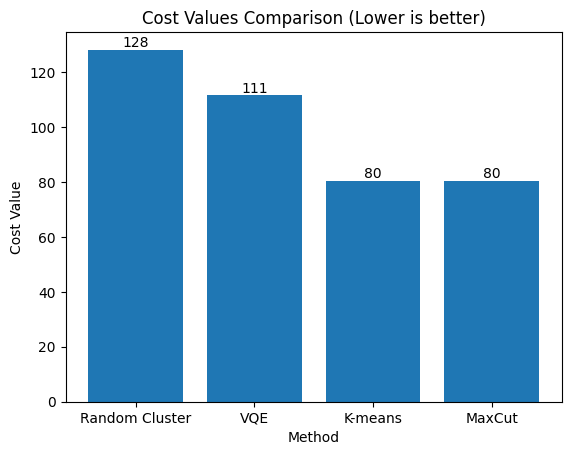

In [14]:
cost_values = [Random_cost, VQE_cost, KMeans_cost, MaxCut_cost]

labels = ["Random Cluster", "VQE", "K-means", "MaxCut"]

plt.bar(labels, cost_values)
for i, v in enumerate(cost_values):
    plt.text(i, v, int(v), ha="center", va="bottom")

plt.xlabel("Method")
plt.ylabel("Cost Value")
plt.title("Cost Values Comparison (Lower is better)")

plt.show()